<a href="https://colab.research.google.com/github/dkormn/NLP/blob/main/nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# FastText Türkçe vektör dosyasını indir
!wget -q https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.tr.300.vec.gz
!gunzip cc.tr.300.vec.gz


gzip: cc.tr.300.vec already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [ ]:
!pip install -q nlpaug
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K
import nlpaug.augmenter.word as naw


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP/ttc4900_extracted/7allV03.csv')

stop_words = set(stopwords.words("turkish"))

def temizle(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return " ".join([w for w in text.split() if w not in stop_words])

df["text"] = df["text"].astype(str).apply(temizle)

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["category"])


<ipython-input-20-c2f9a65231c8>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


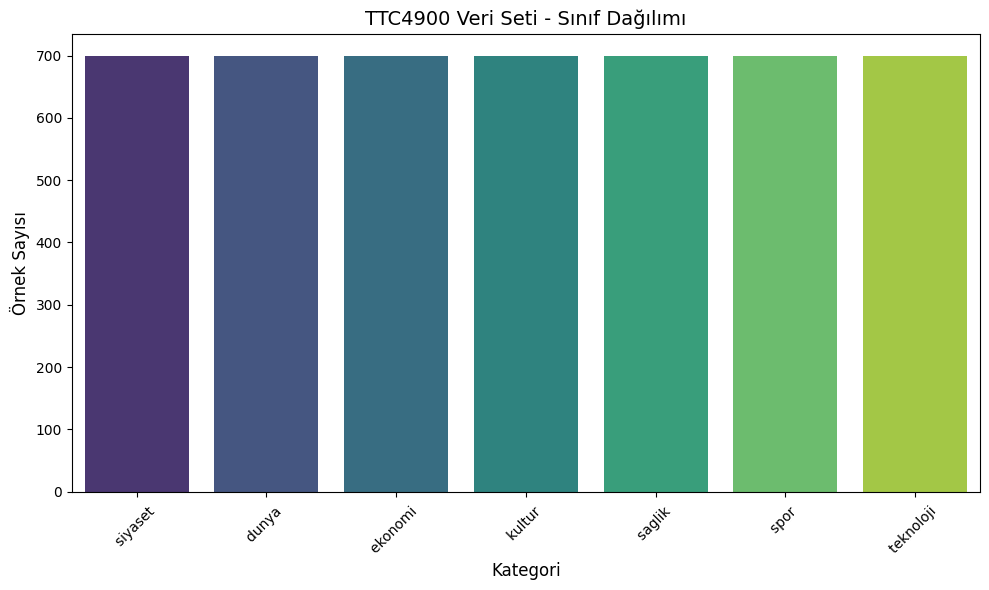

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sınıf dağılımını say
class_counts = df["category"].value_counts()

# Grafik boyutları
plt.figure(figsize=(10, 6))

# Barplot çizimi
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

# Başlık ve etiketler
plt.title("TTC4900 Veri Seti - Sınıf Dağılımı", fontsize=14)
plt.xlabel("Kategori", fontsize=12)
plt.ylabel("Örnek Sayısı", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Grafiği göster
plt.show()


80 10 10

In [ ]:
'''from sklearn.model_selection import train_test_split

# Tüm verileri al
texts = df["text"].tolist()
labels = df["label"].tolist()

# Önce %80 eğitim + %20 (test + val) olacak şekilde ayır
X_train_texts, X_temp_texts, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42)

# Şimdi kalan %20'lik kısmı %10 test ve %10 val olacak şekilde ikiye böl
X_val_texts, X_test_texts, y_val, y_test = train_test_split(
    X_temp_texts, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


# Synonym augmenter
aug = naw.SynonymAug(aug_src='wordnet', lang='turkish')
augmented_texts = []
augmented_labels = []

augment_probabilities = {
    'ekonomi': 0.6,
    'dunya': 0.4,
    'siyaset': 0.5,
    'kultur': 0.1,
    'saglik': 0.0,
    'spor': 0.0,
    'teknoloji': 0.1
}

for text, label in zip(X_train_texts, y_train):
    class_name = label_encoder.inverse_transform([label])[0]
    aug_prob = augment_probabilities.get(class_name, 0.1)

    if random.random() < aug_prob:
        try:
            new_text = aug.augment(text)
            augmented_texts.append(new_text)
            augmented_labels.append(label)
        except:
            pass


"""
SINIF BAZLI AUGMENTATİON DAHA İYİ SONUÇ VERİYOR
aug = naw.SynonymAug(aug_src='wordnet', lang='turkish')

augmented_texts = []
augmented_labels = []

# Augment edilme olasılığı (örnek: %30)
augment_prob = 0.3

# Her metin için augment denemesi
for text, label in zip(X_train_texts, y_train):
    if random.random() < augment_prob:
        try:
            new_text = aug.augment(text)
            augmented_texts.append(new_text)
            augmented_labels.append(label)
        except:
            pass
"""
X_train_texts_aug = X_train_texts + augmented_texts
y_train_aug = y_train + augmented_labels
'''

'from sklearn.model_selection import train_test_split\n\n# Tüm verileri al\ntexts = df["text"].tolist()\nlabels = df["label"].tolist()\n\n# Önce %80 eğitim + %20 (test + val) olacak şekilde ayır\nX_train_texts, X_temp_texts, y_train, y_temp = train_test_split(\n    texts, labels, test_size=0.2, stratify=labels, random_state=42)\n\n# Şimdi kalan %20\'lik kısmı %10 test ve %10 val olacak şekilde ikiye böl\nX_val_texts, X_test_texts, y_val, y_test = train_test_split(\n    X_temp_texts, y_temp, test_size=0.5, stratify=y_temp, random_state=42)\n\n\n# Synonym augmenter\naug = naw.SynonymAug(aug_src=\'wordnet\', lang=\'turkish\')\naugmented_texts = []\naugmented_labels = []\n\naugment_probabilities = {\n    \'ekonomi\': 0.6,\n    \'dunya\': 0.4,\n    \'siyaset\': 0.5,\n    \'kultur\': 0.1,\n    \'saglik\': 0.0,\n    \'spor\': 0.0,\n    \'teknoloji\': 0.1\n}\n\nfor text, label in zip(X_train_texts, y_train):\n    class_name = label_encoder.inverse_transform([label])[0]\n    aug_prob = augment_

70 10 20 verisetinin ayrılması sonucu

In [ ]:
texts = df["text"].tolist()
labels = df["label"].tolist()

# her kategoriden eşit veri alıyor.
X_temp_texts, X_test_texts, y_temp, y_test = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42)

X_train_texts, X_val_texts, y_train, y_val = train_test_split(
    X_temp_texts, y_temp, test_size=0.125, stratify=y_temp, random_state=42)

# Eş anlamlı kelimeler ile veri çeşitliliği
aug = naw.SynonymAug(aug_src='wordnet', lang='turkish')
augmented_texts = []
augmented_labels = []

augment_probabilities = {
    'ekonomi': 0.6,
    'siyaset': 0.5,
    'dunya': 0.4,
    'kultur': 0.1,
    'saglik': 0.0,
    'spor': 0.0,
    'teknoloji': 0.1
}

for text, label in zip(X_train_texts, y_train):
    class_name = label_encoder.inverse_transform([label])[0]
    aug_prob = augment_probabilities.get(class_name, 0.1)

    if random.random() < aug_prob:
        try:
            new_text = aug.augment(text)
            augmented_texts.append(new_text)
            augmented_labels.append(label)
        except:
            pass
"""
SINIF BAZLI AUGMENTATİON DAHA İYİ SONUÇ VERİYOR
aug = naw.SynonymAug(aug_src='wordnet', lang='turkish')

augmented_texts = []
augmented_labels = []

# Augment edilme olasılığı (örnek: %30)
augment_prob = 0.3

# Her metin için augment denemesi
for text, label in zip(X_train_texts, y_train):
    if random.random() < augment_prob:
        try:
            new_text = aug.augment(text)
            augmented_texts.append(new_text)
            augmented_labels.append(label)
        except:
            pass
"""
X_train_texts_aug = X_train_texts + augmented_texts
y_train_aug = y_train + augmented_labels


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

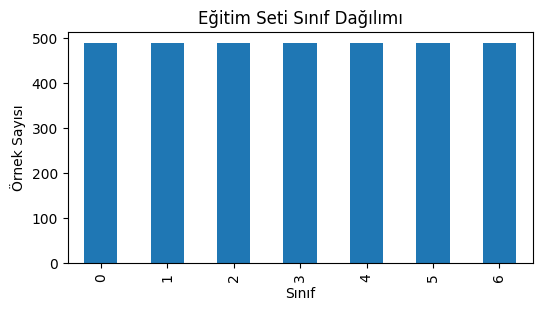

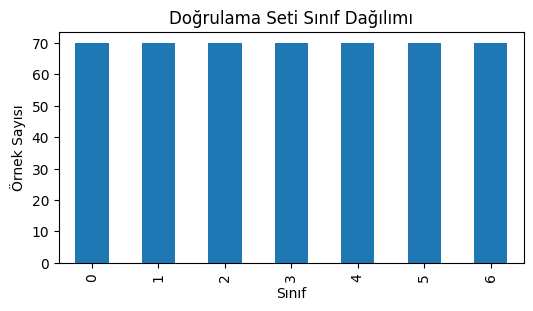

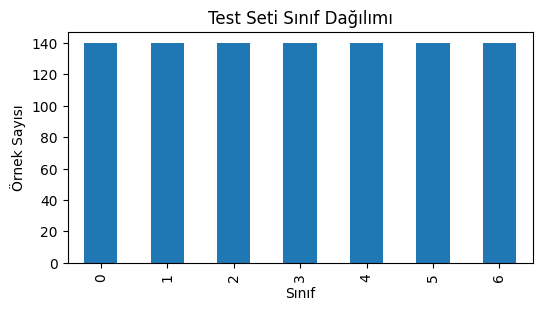

In [ ]:
import matplotlib.pyplot as plt

def plot_class_distribution(y, title):
    plt.figure(figsize=(6, 3))
    pd.Series(y).value_counts().sort_index().plot(kind='bar')
    plt.title(title)
    plt.xlabel('Sınıf')
    plt.ylabel('Örnek Sayısı')
    plt.show()

plot_class_distribution(y_train, "Eğitim Seti Sınıf Dağılımı")
plot_class_distribution(y_val, "Doğrulama Seti Sınıf Dağılımı")
plot_class_distribution(y_test, "Test Seti Sınıf Dağılımı")


In [ ]:
max_words = 10000  # En fazla kullanılacak kelime sayısı
max_len = 100      # Her cümlede kullanılacak maksimum kelime sayısı

# En sık geçen '10000' kelime
tokenizer = Tokenizer(num_words=max_words)

# Sözlük oluşturma
tokenizer.fit_on_texts(X_train_texts_aug + X_val_texts + X_test_texts)

# Metinler sözlüğe bakarak tamsayı dizisine çevirme
X_train_seq = tokenizer.texts_to_sequences(X_train_texts_aug)
X_val_seq = tokenizer.texts_to_sequences(X_val_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

# Dizi uzunluklarını sabitle
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Etiket dizisini numpy array'e çevir (model eğitimi için gerekli)
y_train_aug = np.array(y_train_aug)


In [ ]:
embedding_dim = 300  # Her kelime 300 boyutlu vektörle temsil edilecek
embedding_index = {}  # Kelime → vektör sözlüğü

# FastText gömme (embedding) dosyasını oku
with open('cc.tr.300.vec', 'r', encoding='utf-8') as f:
    next(f)
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Modelin kullanacağı embedding matrisini oluştur (başlangıçta tüm değerler sıfır)
embedding_matrix = np.zeros((max_words, embedding_dim))

# Embedding e tokenizer tarafından bulunan kelimeleri ekleme
for word, i in tokenizer.word_index.items():
    if i < max_words:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector  #Bu matrix i aşağıda embedding e önceden eğitilmiş kelime vektörleri olarak veriyoruz


In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW,Adam
from tensorflow.keras.layers import Bidirectional, LSTM

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32) # Etiketleri tamsayıya çevir (güvenlik amaçlı)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1]) # Etiketleri one-hot formata çevir

        # Küçük sabit ile tahminleri kırp (log(0) hatasından kaçınmak için)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true_one_hot * K.log(y_pred) # Cross-entropy (klasik log loss)
        weight = alpha * K.pow(1 - y_pred, gamma) # Focal Loss için ağırlık: kolay örnekler az etki eder
        loss = weight * cross_entropy # Ağırlıklı kayıp değeri

        # Her örnek için toplam kayıp
        return K.sum(loss, axis=1)

    return focal_loss_fixed,

# Giriş katmanı: Her örnek sabit uzunlukta bir tamsayı dizisi (örneğin token ID'leri)
input_layer = Input(shape=(max_len,))

# Gömme (embedding) katmanı: Her kelimeyi 300 boyutlu vektöre çevir
embedding = Embedding(
    input_dim=max_words,         # Kelime sayısı (sözlükteki maksimum kelime ID'si)
    output_dim=300,              # Her kelimenin vektör boyutu (Bizim için: FastText deki her kelime 300 vektörlü olduğu için)
    weights=[embedding_matrix],  # Önceden eğitilmiş gömme matrisini kullan
    input_length=max_len,        # Giriş dizisinin maksimum uzunluğu
    trainable=True               # Gömme vektörleri(FastText) eğitim sırasında güncellenecek (False yaparsan sabit kalır)
)(input_layer)


# CNN dalları
# embedding
#   ├── CNN(3,5,7) + pooling
#   └── BiLSTM + pooling
# → concat
# → dense
conv3 = Conv1D(64, 3, activation='relu')(embedding) # 64 katmanda çıkan özellik haritası, filtre farklı kalıp farklı özellik
conv5 = Conv1D(64, 5, activation='relu')(embedding) #relu doğrusal olmayan ilişki öğrenmesi,negatif 0lar model hızlanır, etkili öğrenme
conv7 = Conv1D(64, 7, activation='relu')(embedding)

pool3 = GlobalMaxPooling1D()(conv3) # en güçlü değer
pool5 = GlobalMaxPooling1D()(conv5)
pool7 = GlobalMaxPooling1D()(conv7)

bilstm = Bidirectional(LSTM(64, return_sequences=True))(embedding) # her kelimeye karşılık gelen gizli durumu verir, vektör ister
bilstm_pool = GlobalMaxPooling1D()(bilstm)

# Hepsini birleştir
concat = Concatenate()([pool3, pool5, pool7, bilstm_pool])

# Dense katman
dense = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(concat) # 128 nöronlu fully connected

# Burası bir önceki hali
# conv3 = Conv1D(64, 3, activation='relu')(embedding)
# conv5 = Conv1D(64, 5, activation='relu')(embedding)
# conv7 = Conv1D(64, 7, activation='relu')(embedding)

# pool3 = GlobalMaxPooling1D()(conv3)
# pool5 = GlobalMaxPooling1D()(conv5)
# pool7 = GlobalMaxPooling1D()(conv7)

# concat = Concatenate()([pool3, pool5, pool7])
# dense = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(concat)
drop = Dropout(0.5)(dense)
output = Dense(len(label_encoder.classes_), activation='softmax')(drop) # her sınıfa ait olasılık üretilir

model = Model(inputs=input_layer, outputs=output)

# Modeli compile ederken optimizer'ı kullan
# optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy'])

# model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 300)  │  3,000,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 98, 64)    │     57,664 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 96, 64)    │     96,064 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 94, 64)    │    134,464 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 100, 128)  │    186,880 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_4[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_5[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional_1[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 320)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     41,088 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7)         │        903 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,517,063 (13.42 MB)

 Trainable params: 3,517,063 (13.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.3173 - loss: 0.3287 - val_accuracy: 0.7551 - val_loss: 0.1428 - learning_rate: 0.0010
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7896 - loss: 0.1107 - val_accuracy: 0.8306 - val_loss: 0.0870 - learning_rate: 0.0010
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9354 - loss: 0.0436 - val_accuracy: 0.8449 - val_loss: 0.0802 - learning_rate: 0.0010
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9713 - loss: 0.0255 - val_accuracy: 0.8531 - val_loss: 0.0738 - learning_rate: 0.0010
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9872 - loss: 0.0177 - val_accuracy: 0.8735 - val_loss: 0.0737 - learning_rate: 0.0010
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9975 - loss: 0.0143 - val_accuracy: 0.8612 - val_loss: 0.0823 - learning_rate: 0.0010
Epoch 7/20
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9975 - loss: 0.0133
Epoch 7: 

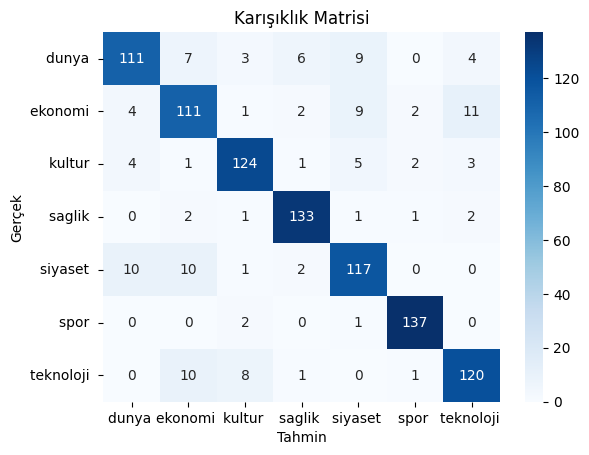

              precision    recall  f1-score   support

      dunya        0.86      0.79      0.83       140
    ekonomi        0.79      0.79      0.79       140
     kultur        0.89      0.89      0.89       140
     saglik        0.92      0.95      0.93       140
    siyaset        0.82      0.84      0.83       140
       spor        0.96      0.98      0.97       140
  teknoloji        0.86      0.86      0.86       140

    accuracy                           0.87       980
   macro avg       0.87      0.87      0.87       980
weighted avg       0.87      0.87      0.87       980



In [ ]:
from pickle import TRUE
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # Öğrenme oranını yarıya indirir
    patience=2,         # 2 epoch boyunca gelişme yoksa uygular
    min_lr=1e-5,        # Öğrenme oranı bu değerin altına inemez
    verbose=1           # Azaltma yapıldığında bilgi verir
)

y_train_aug = np.array(y_train_aug)
y_val = np.array(y_val)
y_test = np.array(y_test)


history = model.fit( # Modelin eğitimesi
    X_train_pad, y_train_aug,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=64, # Her seferde 64 örnek
    callbacks=[early_stop, reduce_lr], # Eğitim sürecini kontrol eden yapılar
    verbose=1,
)

loss, acc = model.evaluate(X_test_pad, y_test)
print(f"\nTest doğruluğu: {acc:.4f}")

# Tahminler
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1) # en yüksek sınıfa ait olasılık seçilir

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Karışıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

In [ ]:
import random

# Test verisinden rastgele bir örnek seç
random_index = random.randint(0, len(X_test_pad) - 1)
random_text = X_test_texts[random_index]  # Ham metni yazdırmak için
true_label = y_test[random_index]
predicted_label = y_pred_classes[random_index]

# Etiket isimleri varsa (örneğin label2class sözlüğü), daha anlamlı göstermek için
label2class = {0: "dunya", 1: "ekonomi", 2: "kultur", 3: "saglik", 4: "siyaset", 5: "spor", 6: "teknoloji"}

print("\nRastgele Seçilen Metin:\n", random_text)
print("\nModelin Tahmini Kategori:", label2class[predicted_label])
print("Gerçek Kategori:", label2class[true_label])



Rastgele Seçilen Metin:
 faturanız yüksek geliyorsa dikkat cep faturanız beklediğinizden fazla geldiyse nedeni cep telefonu virüsleri cep telefonunuza bulaşan virüsler cep telefonu güvenilir olmayan internet sitelerini dolaştığınızda bulaşıyor cep telefonunuzdan yurt dışı numaralarına mesaj çağrı gidiyor bilgisayarların yerini cep telefonları alınca hackerler yön değiştirdi cep telefonu internete giren cep telefonu kullanıcıları sikayetvar com a gönderdikleri şikayetlerle yüksek cep faturalarından şikayet ettiler cep numaramdan bilmediğim yurtdışı numaralarına mesaj çağrı gitmiş şeklinde gelen şikayetler incelendiğinde ilginç bir detay ortaya çıktı kabarık faturaların nedeni virüsler çıktı çeşitli numaralara mesaj gönderiyor işte kabarık cep faturalarından dert yanan cep telefonu kullanıcılarının ortak şikayetleri şöyle internete cep telefonları aracılığıyla bağlanan kullanıcıları bekleyen virüslerin sayısı gün geçtikçe artıyor hackerler güvenli olmayan internet sitelerine zararlı kod